### **Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

### This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

### Another important variable is **adherence**, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. **Note:** When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wego = pd.read_csv("../data/headway_data.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [3]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

In the data, the bus route can be identified by its ROUTE_ABBR value.
3: West End
7: Hillsboro
22: Bordeaux
23: Dickerson Pike
50: Charlotte Pike
52: Nolensville Pike
55: Murfreesboro Pike
56: Gallatin Pike

In [4]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25959
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

The trip can be identified by the DATE/CALENDAR_ID plus the TRIP_ID.
Warning: The TRIP_ID refers to the route and time but will be used across multiple days.

The data contains multiple time points for each trip. There are more stops along the route than time points, but the time points are the points with specific scheduled times the bus operators must adhere to.

The first stop of a trip has a TRIP_EDGE of 1, the last has a TRIP_EDGE of 2, and the intermediate stops are TRIP_EDGE 0.

In [7]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

# 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [17]:
wego['ADJUSTED_ONTIME_COUNT'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

ADJUSTED_ONTIME_COUNT
1    77.1%
0    22.9%
Name: proportion, dtype: object

In [46]:
wego['ADHERENCE'].value_counts().sort_index().tail(30)

ADHERENCE
62.500000    1
64.766666    1
65.350000    1
65.483333    1
66.533333    1
67.516666    1
67.650000    1
68.433333    1
69.050000    1
69.700000    1
71.200000    1
71.933333    1
71.983333    1
72.083333    1
72.400000    1
72.816666    1
72.850000    1
73.033333    1
73.633333    1
73.750000    1
75.300000    1
75.583333    1
75.983333    1
76.633333    1
76.700000    1
76.766666    1
78.733333    1
84.666666    1
85.666666    1
88.383333    1
Name: count, dtype: int64

In [47]:
wego['HDWY_DEV'].value_counts().sort_index().tail(30)

HDWY_DEV
144.600000    1
146.300000    1
148.400000    1
148.866666    1
155.033333    1
155.183333    1
164.766666    1
166.000000    1
175.766666    1
180.016666    1
181.816666    1
182.216666    1
184.833333    1
189.750000    1
199.866666    1
204.550000    1
204.716666    1
210.866666    1
238.983333    1
241.716666    1
255.783333    1
361.033333    1
405.133333    1
472.366666    1
498.066666    1
505.233333    1
508.700000    1
529.550000    1
543.833333    1
565.433333    1
Name: count, dtype: int64

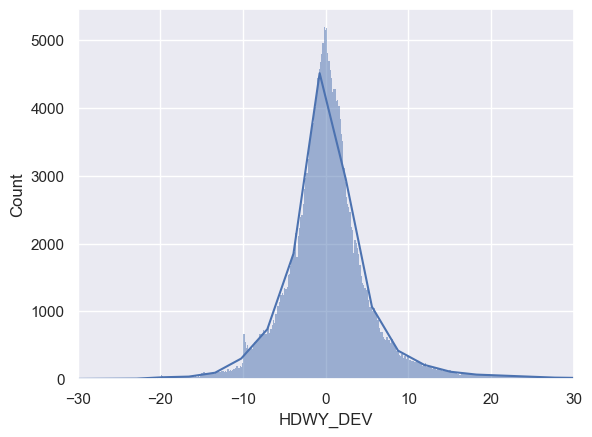

In [45]:
sns.set_theme(style="darkgrid")
sns.histplot(data=wego, x=wego['HDWY_DEV'], kde=True)
plt.xlim(left=-30, right=30)
plt.show()

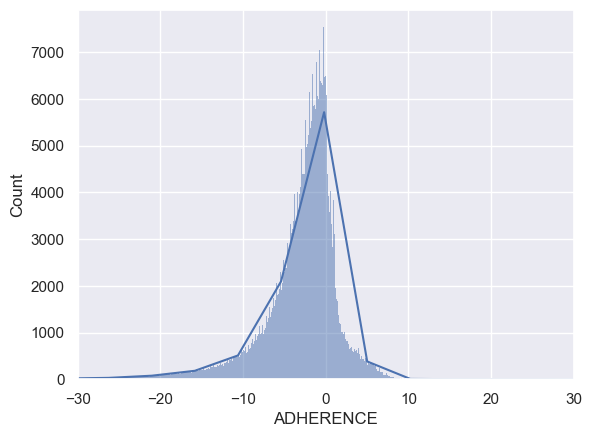

In [48]:
sns.set_theme(style="darkgrid")
sns.histplot(data=wego, x=wego['ADHERENCE'], kde=True)
plt.xlim(left=-30, right=30)
plt.show()

(-30.0, 30.0)

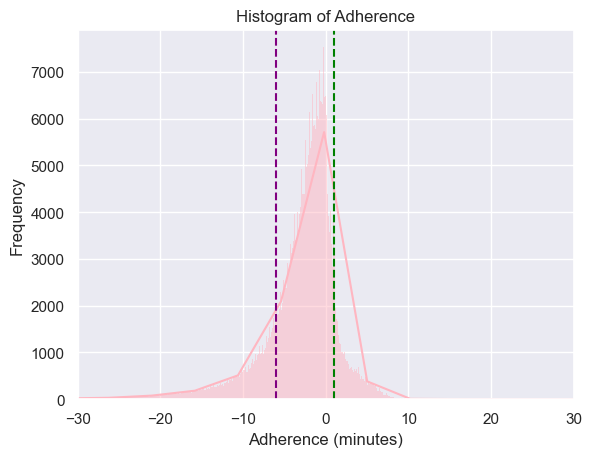

In [44]:
sns.histplot(wego['ADHERENCE'], kde=True, color='lightpink')
plt.title('Histogram of Adherence')
plt.xlabel('Adherence (minutes)')
plt.ylabel('Frequency')
plt.axvline(x=-6, color='purple', linestyle='--', label='Late Threshold (-6 min)')  # Adding a line indicating late threshold
plt.axvline(x=1, color='green', linestyle='--', label='Early Threshold (1 min)')  # Addin a line indicating early threshold
plt.xlim(left=-30, right=30)

# 2. How does direction of travel, route, or location affect the headway and on-time performance?

# 3. How does time of day or day of week affect headway and on-time performance?

# 4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

# 5. Is there any relationship between lateness (ADHERENCE) and headway deviation?